In [1]:
import torch as t
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
from einops import rearrange

from my_transformer import TransformerConfig, DecoderOnlyTransformer

In [2]:
class CustomTextDataset(Dataset):
    def __init__(self, vocab_size: int, seq_len: int, datasize: int):
        self.seqs = t.randint(0, vocab_size, (datasize, seq_len))

    def __len__(self):
            return len(self.seqs)

    def __getitem__(self, idx):
            input = self.seqs[idx]
            target = t.flip(input, dims=(0,))
            return (input, target)

In [3]:
config = TransformerConfig(
    num_layers=2,
    num_heads=4,
    vocab_size=10,
    hidden_size=48,
    max_seq_len=6,
    dropout=0.1,
    layer_norm_epsilon=1e-05
)

trainset = CustomTextDataset(
    vocab_size=config.vocab_size,
    seq_len=config.max_seq_len,
    datasize=1000
)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)


In [4]:
# Take a peak at an (input, target) pair from the trainloader
trainloader.dataset[0]

(tensor([4, 9, 2, 9, 8, 2]), tensor([2, 8, 9, 2, 9, 4]))

In [5]:
model = DecoderOnlyTransformer(config)
optimizer = t.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_losses = []

In [6]:
# Test the model on the first few datapoints
model.eval()
for i in range(10):
    with t.no_grad():
        input, target = trainset[i]
        output = model(input).argmax(dim=-1)
        print(input, output, target)

tensor([4, 9, 2, 9, 8, 2]) tensor([4, 9, 2, 9, 8, 2]) tensor([2, 8, 9, 2, 9, 4])
tensor([3, 1, 6, 2, 2, 7]) tensor([3, 1, 6, 2, 2, 7]) tensor([7, 2, 2, 6, 1, 3])
tensor([1, 9, 1, 1, 1, 0]) tensor([1, 9, 1, 1, 1, 0]) tensor([0, 1, 1, 1, 9, 1])
tensor([2, 1, 8, 9, 3, 7]) tensor([2, 1, 8, 9, 3, 7]) tensor([7, 3, 9, 8, 1, 2])
tensor([9, 5, 1, 9, 2, 8]) tensor([9, 5, 1, 9, 2, 8]) tensor([8, 2, 9, 1, 5, 9])
tensor([8, 8, 1, 6, 0, 6]) tensor([8, 8, 1, 6, 0, 6]) tensor([6, 0, 6, 1, 8, 8])
tensor([4, 9, 5, 9, 5, 7]) tensor([4, 9, 5, 9, 5, 7]) tensor([7, 5, 9, 5, 9, 4])
tensor([5, 1, 5, 3, 2, 7]) tensor([5, 1, 5, 3, 2, 7]) tensor([7, 2, 3, 5, 1, 5])
tensor([5, 5, 9, 8, 6, 0]) tensor([5, 5, 9, 8, 6, 0]) tensor([0, 6, 8, 9, 5, 5])
tensor([5, 3, 7, 4, 8, 3]) tensor([5, 3, 7, 4, 8, 3]) tensor([3, 8, 4, 7, 3, 5])


In [7]:
# View the logits produced on the first datapoint
model.eval()
with t.no_grad():
    logits = model(trainset[0][0])
logits

tensor([[-12.7653,  -8.7106,  -4.9278,  -5.0449,  38.4866,   9.1376,   4.6578,
          -6.5536, -10.9397,  -5.9392],
        [ -7.5714, -14.2129,  -3.0395,  -5.1020,  -3.5640,  -8.0693,  -8.6857,
           9.5489,  11.9702,  46.8874],
        [ -4.1407,  -6.8299,  46.1375,   2.8813,  -5.2167,  13.6722,  -3.6969,
          -2.5647,  -6.2124,  -3.6502],
        [ -6.0516, -12.4106,  -0.1945,  -4.0177,  -0.5814,  -5.3783, -10.1912,
           6.9940,   8.3550,  45.8515],
        [  7.0773, -10.7890,  -1.4051,  -8.5924,  -8.5758,  10.4038,  -3.6772,
           9.7778,  39.4988,   9.9840],
        [  1.3078,  -4.7722,  44.8890,   2.4936,  -3.7719,  13.4666,  -4.4189,
          -3.0231,  -8.2291,  -6.3323]])

In [8]:
NUM_EPOCHS = 100

model.train()
for epoch in range(1, NUM_EPOCHS + 1):
    for inputs, targets in trainloader:
        
        outputs = model(inputs)
        
        loss = criterion(
            rearrange(outputs, 'batch seq vocab -> (batch seq) vocab'),
            rearrange(targets, 'batch seq -> (batch seq)')
        )
        train_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

<AxesSubplot:>

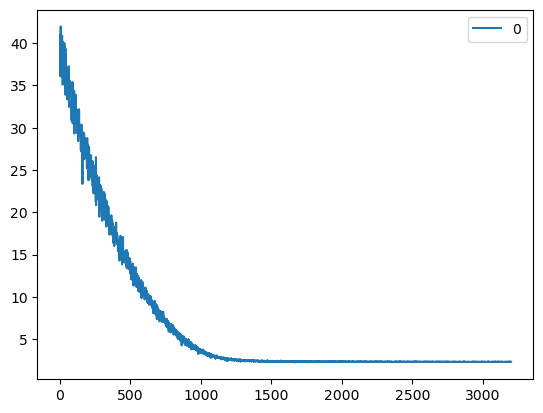

In [18]:
df = pd.DataFrame(train_losses)
df.plot()


In [10]:
# Test the model again on the first few datapoints
model.eval()
for i in range(10):
    with t.no_grad():
        input, target = trainset[i]
        output = model(input).argmax(dim=-1)
        print(input, output, target)

tensor([4, 9, 2, 9, 8, 2]) tensor([8, 1, 5, 1, 4, 2]) tensor([2, 8, 9, 2, 9, 4])
tensor([3, 1, 6, 2, 2, 7]) tensor([3, 9, 5, 5, 2, 7]) tensor([7, 2, 2, 6, 1, 3])
tensor([1, 9, 1, 1, 1, 0]) tensor([9, 1, 9, 9, 9, 0]) tensor([0, 1, 1, 1, 9, 1])
tensor([2, 1, 8, 9, 3, 7]) tensor([3, 9, 3, 1, 5, 7]) tensor([7, 3, 9, 8, 1, 2])
tensor([9, 5, 1, 9, 2, 8]) tensor([1, 5, 9, 1, 2, 4]) tensor([8, 2, 9, 1, 5, 9])
tensor([8, 8, 1, 6, 0, 6]) tensor([8, 8, 9, 5, 0, 7]) tensor([6, 0, 6, 1, 8, 8])
tensor([4, 9, 5, 9, 5, 7]) tensor([8, 1, 5, 1, 5, 7]) tensor([7, 5, 9, 5, 9, 4])
tensor([5, 1, 5, 3, 2, 7]) tensor([5, 9, 5, 5, 2, 7]) tensor([7, 2, 3, 5, 1, 5])
tensor([5, 5, 9, 8, 6, 0]) tensor([5, 5, 1, 4, 0, 0]) tensor([0, 6, 8, 9, 5, 5])
tensor([5, 3, 7, 4, 8, 3]) tensor([5, 3, 7, 5, 4, 8]) tensor([3, 8, 4, 7, 3, 5])


In [11]:
# View the logits produced on the first datapoint
model.eval()
with t.no_grad():
    logits = model(trainset[0][0])
logits

tensor([[0.5428, 0.3856, 0.4879, 0.5446, 0.2943, 0.4949, 0.3048, 0.5748, 0.6991,
         0.5752],
        [0.5617, 0.8303, 0.5012, 0.5794, 0.5784, 0.6878, 0.5013, 0.4921, 0.6656,
         0.7682],
        [0.2920, 0.4736, 0.5108, 0.4822, 0.4857, 0.5860, 0.4442, 0.4049, 0.4107,
         0.5018],
        [0.6282, 0.8735, 0.6300, 0.5419, 0.7195, 0.8048, 0.4876, 0.4713, 0.6161,
         0.7746],
        [0.4480, 0.5538, 0.4426, 0.5231, 0.7032, 0.6103, 0.4339, 0.4556, 0.6143,
         0.6279],
        [0.2836, 0.2761, 0.4863, 0.2474, 0.4732, 0.4094, 0.3599, 0.4025, 0.4068,
         0.4173]])